In [1]:
import pandas as pd
import numpy as np
import re
from datetime import datetime, time, date, timedelta
import sys 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.ticker import MaxNLocator
%matplotlib inline
import logging
import matplotlib.patches as patches

In [2]:
#### PARAMETERS ####
#FULL DATASET ANALYSIS###
param_starttime = "08:00"
param_endtime = "18:30"
increment = "1" # min minutes
#### PARAMETERS ####

In [3]:
#opening csv file provided by company - may need to clean up
dfraw = pd.read_csv("phonesystem_mod.csv", usecols=np.arange(14))
#dfraw = dfraw.reset_index()
#store number of rows and cols
row, col = dfraw.shape


In [4]:
#after looking at the data we want to clean it up
#lets drop un-needed cols.
del dfraw['Unique ID']
del dfraw['Caller Extension']
del dfraw['Caller Comments']
del dfraw['Called Comments']
del dfraw['Answering Extension']
del dfraw['Information']
del dfraw['Reporting Group']
del dfraw['Report Flag']

In [5]:
# The dates and times given in the data needs to be of type "datetime"
#We extract the date and time now. 
#Construct datetime object (YYYY,MM,DD,hour,min,sec) by extracting it by slice

#create new column with same number of index:
#empty col ready to transfer formatted datetime values
dfraw["datetime"] = '' 

# store the rows of data into this temporary pandas series
dt_col = dfraw["Date/Time"] 

i = 0

for dt_ele in dt_col:
    
    # "dt_ele" contains a string: dd/mm/yyyy hh:mm:ss <-- lets extract this
    #by looping through each point of our date/time col and extracting
    #individual data by slicing:
    year = dt_ele[6:10]
    month = dt_ele[3:5]
    day = dt_ele[0:2]
    hour = dt_ele[11:13]
    mini = dt_ele[14:16]
    sec = dt_ele[17:21]
    
    #create a datetime object for that element
    formatted_dt = datetime(int(year),int(month),int(day),int(hour),int(mini),int(sec))

    #plug this formatted datetime value into our new col called datetime by appending.
    #as we are looping from the begining of the col
    dfraw.loc[i,"datetime"] = formatted_dt
    
    i = i + 1

In [6]:
#drop the unformatted date/time col
del dfraw['Date/Time']
#re-arrage the cols
collist = ["datetime","Type","Dial Status","Caller Number","Called Number","Duration"]
dfraw = dfraw[collist]


In [7]:
dfraw = dfraw.sort_values("datetime")
#we sorted the datetimes. now we need to reset the index values:
dfraw = dfraw.reset_index(drop=True)

#so we know first datetime[] row is earliest 
#and last row is latest. store these dates and print.
firstdate = dfraw.loc[0,"datetime"]
lastdate = dfraw.loc[row-1,"datetime"]

In [8]:
#clean data further by dropping rows with times outside user defined: param_starttime and param_endtime

dummystarttime = datetime(int("1990"),int("01"),int("01"),
                     int(param_starttime[0:2]),
                     int(param_starttime[3:5]))
dummyendtime = datetime(int("1990"),int("01"),int("01"),
                     int(param_endtime[0:2]),
                     int(param_endtime[3:5]))


dfraw["timeonly"] = ""
rowcounter = 0
for ele in dfraw["datetime"]:
    dfraw.loc[rowcounter,"timeonly"] = ele.time()
    rowcounter += 1
    
#remove data that is no within the bounds of our target timeframe
dfraw = dfraw[dfraw.timeonly > dummystarttime.time()]
dfraw = dfraw[dfraw.timeonly < dummyendtime.time()]
#WE JUST DELETED ROWS. must reset the index!!!!! otherwise there are jumps in the index 
dfraw = dfraw.reset_index(drop=True)


In [9]:
#create empty df with dates in one col and col headers named:from start time
#to end time

coldate_list = []# list of the dates in the datetime column
dumpdate = firstdate
while dumpdate <= lastdate:
    coldate_list.append(dumpdate.date())
    dumpdate += timedelta(days=1)

dfmain = pd.DataFrame(coldate_list,columns=["Dates"])

dummytime = dummystarttime
##generate a list of times from start time to end time going up in user 
#defined increments:

while dummytime.time() <= dummyendtime.time():
    dfmain[dummytime.time()]= 0
    dummytime += timedelta(minutes=int(increment))
#dfmain is ready to store "count" values for each day for each time increment
 
dfmain = dfmain.set_index('Dates')    



In [10]:
##CHECK OUR PARAMETERS##

#convert a time mm:ss into datetime with random date. ??why?? - to check user given parameters. 
#we dont care about the date as we are only interested in the time component
def text2date_nullDate (giventime):
    #expect a string in the format: mm:ss
    thetime_nullDate = datetime(int("1990"),int("01"),int("01"),
                               int(giventime[0:2]),
                               int(giventime[3:5]))
    return thetime_nullDate



#check if usr given starttime is of format mm/ss
try:
    usr_starttime = text2date_nullDate(param_starttime)
except ValueError:
    print("StartTime given in parameters is not of form: mm/ss")
    sys.exit()    
    
#check if usr given endtime is of format mm/ss
try:
    usr_endtime = text2date_nullDate(param_endtime)
except ValueError:
    print("EndTime given in parameters is not of form: mm/ss")
    sys.exit()
 

In [11]:
#convert yyyy-mm-dd into datetime object with 00:00 time
#this is needed for converting the date from string to datetime.
def text2Date_nullTime (givendate):
    #expect a string in the format: yyyy-mm-dd
    thedate = datetime(int(givendate[0:4]),
                    int(givendate[5:7]),
                    int(givendate[8:10]),)
    return thedate

In [12]:
count = 0
dfraw_rownum = 0 
dfraw_element = dfraw.loc[dfraw_rownum,"datetime"] 

dfSingle_rowindex = 0 #use as a counter to reference which row "dfSingle["Time"]"is on


datetimeincrements = list(dfmain) #the list of cols in dfmain. use this list to loop through these are datetime.time()
datetimeincrements.pop(0) # get rid of the header

#curr_date = text2Date_nullTime(dfmain.loc[0,"Dates"]) # start with the first date. 
curr_dfmainrow = 0 # a row number counter to specify which row we are on wrt curr_date

data = dfraw["datetime"]
data_row = 0
count = 0


for dfraw_rownum in range(len(dfraw["datetime"])):
    dp_date = dfraw.loc[dfraw_rownum,"datetime"].date()
    dp_time = dfraw.loc[dfraw_rownum,"datetime"].time()
    #we have the datapoint. now test if its inbound and answered: 
    #- if so then go in the corresponding dfmain cell and (+1) to the cell
    if dfraw.loc[dfraw_rownum,"Dial Status"] == "Answered" and dfraw.loc[dfraw_rownum,"Type"] == "INBOUND":
        timerange_incr = dp_time.replace(second=0)
        temp = dfmain.loc[dp_date,timerange_incr]
        temp +=1
        dfmain.loc[dp_date,timerange_incr] = temp

In [13]:
#dfmain has our analysed data. lets plot it now
#everyday we have a plot of all incomming calls. we will plot it all ontop of each other to see during which times
#have a higher density of calls. and perhaps gain some insight. 

In [14]:
dfmain
#x = dfmain.mean()
#print(x)
#y = dfmain.max()
#print(y)

#fig = plt.figure(figsize=(10,5))
#ax = fig.add_axes(0,0,1,1)
#ax = plt.plot(dfmain[""])

,08:00:00,08:01:00,08:02:00,08:03:00,08:04:00,08:05:00,08:06:00,08:07:00,08:08:00,08:09:00,...,18:21:00,18:22:00,18:23:00,18:24:00,18:25:00,18:26:00,18:27:00,18:28:00,18:29:00,18:30:00
Dates,,,,,,,,,,,,,,,,,,,,,
2019-01-28,0,0,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2019-01-29,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-01-30,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
#Reshape the dfmain for suitable porting into matplotlib
dfmain_plot = pd.DataFrame(columns=["time","datetime","avg","max"])
col_headers = list(dfmain)

dfmain_plot["time"]= col_headers
dfmain_plot = dfmain_plot.set_index("time")

for time in list(dfmain_plot.index.values):
    avg = dfmain[time].mean()
    maxi = dfmain[time].max()
    dt = datetime.combine(datetime.today().date(),time) #doing this for label formatting in our graph
    dfmain_plot.loc[time,"avg"] = float(avg)
    dfmain_plot.loc[time,"max"] = float(maxi)
    dfmain_plot.loc[time,"datetime"] = dt

dfmain_plot = dfmain_plot.set_index("datetime", drop=True)
dfmain_plot.head()


,avg,max
datetime,,
2019-06-01 08:00:00,0.333333,1
2019-06-01 08:01:00,0,0
2019-06-01 08:02:00,0,0
2019-06-01 08:03:00,0.333333,1
2019-06-01 08:04:00,0.666667,1


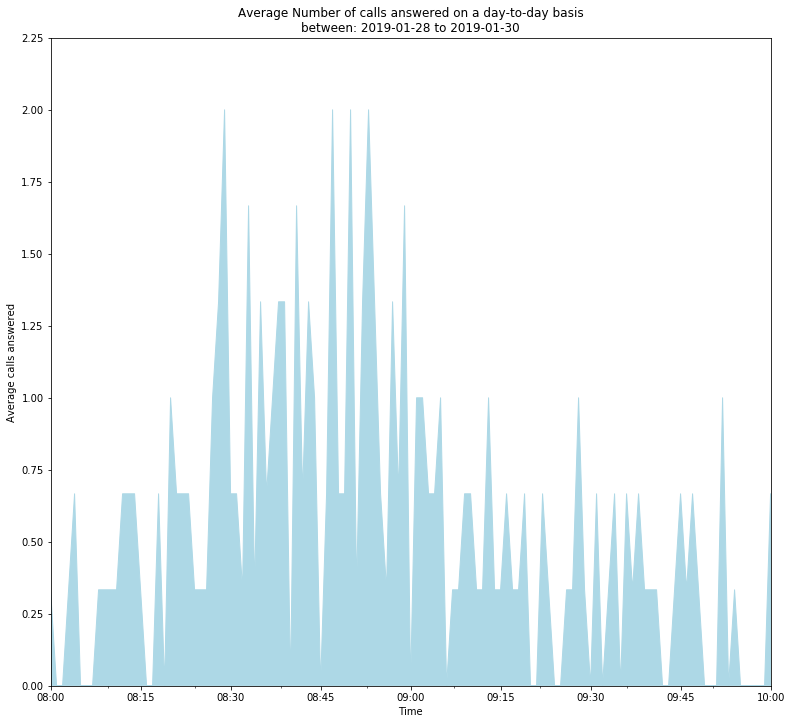

In [16]:
#Average number of calls between a certain part of the day: eg 8:00 - 10:00 (user defined)
mintime = "08:00"
maxtime = "10:00"
min_t = datetime(int("1990"),int("01"),int("01"),int(mintime[0:2]),int(mintime[3:5]))
max_t = datetime(int("1990"),int("01"),int("01"),int(maxtime[0:2]),int(maxtime[3:5]))
min_t = datetime.combine(datetime.today().date(),min_t.time())
max_t = datetime.combine(datetime.today().date(),max_t.time())

fig = plt.figure(figsize=(10,9))
dfmain_plot = dfmain_plot.apply(pd.to_numeric, errors='ignore')

ax = fig.add_axes([0,0,1,1])#(xO,yO,w,h)

#ax.plot(dfmain_plot.index.values, dfmain_plot["avg"],linewidth=2,color="lightblue")
ax.fill_between(dfmain_plot.index.values, dfmain_plot["avg"],color="lightblue")

ax.set_xlabel("Time")
ax.set_ylabel("Average calls answered")
ax.set_title(f"Average Number of calls answered on a day-to-day basis\nbetween: {dfmain.index.min()} to {dfmain.index.max()}")
####set major ticks format
ax.set_xlim(min_t,max_t)
ax.set_ylim(0,dfmain_plot["avg"].max()+0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_minor_locator(MaxNLocator(integer=True))